Code 1: Load and explore the combined red and white wine dataset

In [2]:
import pandas as pd

# Load datasets
red_df = pd.read_csv('winequality-red.csv', sep=';')
white_df = pd.read_csv('winequality-white.csv', sep=';')

# Add 'type' column
red_df['type'] = 'red'
white_df['type'] = 'white'

# Combine datasets
df = pd.concat([red_df, white_df], ignore_index=True)
print(df.shape)
print(df.columns)
print(df.head(2))
print(df.isnull().sum())

(6497, 13)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70          0.0             1.9      0.076   
1            7.8              0.88          0.0             2.6      0.098   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   

   alcohol  quality type  
0      9.4        5  red  
1      9.8        5  red  
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH      

Code 2: Correlation heatmap

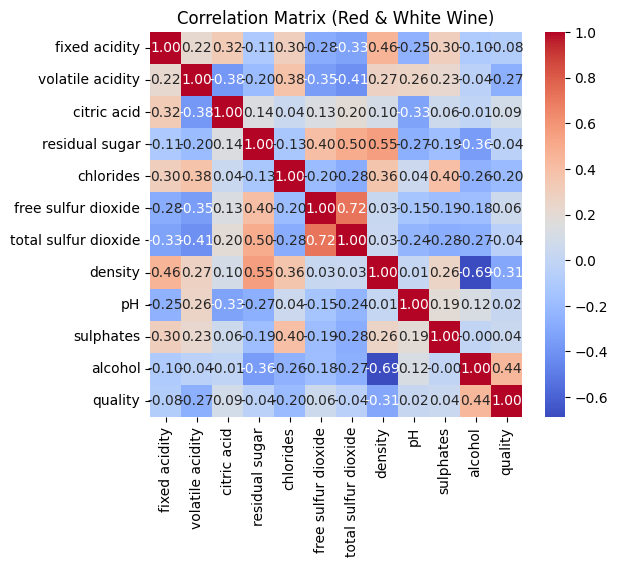

Alcohol feature descriptive stats:
mean    10.491801
std      1.192712
Name: alcohol, dtype: float64


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.drop('type', axis=1).corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Red & White Wine)")
plt.show()

# Code 2.1: Descriptive statistics for 'alcohol'
print("Alcohol feature descriptive stats:")
print(df['alcohol'].describe()[['mean','std']])

Code 3: Preprocess the data and sample it

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer

# Make a clean copy first
df_cleaned = df.copy()

# Encode wine type as numeric
df_cleaned['type'] = df_cleaned['type'].map({'red': 0, 'white': 1})

# Binary classification: label = 1 if quality >= 6, else 0
df_cleaned['label'] = (df_cleaned['quality'] >= 6).astype(int)

# Drop 'quality' to avoid confusion (since we now use 'label')
df_cleaned = df_cleaned.drop('quality', axis=1)

# Split into features and labels
X = df_cleaned.drop('label', axis=1)
y = df_cleaned['label']

# Combine for resampling (clean column names)
combined = pd.concat([X, y], axis=1)

# Separate majority and minority classes
majority = combined[combined['label'] == 1]
minority = combined[combined['label'] == 0]

# Resample minority class
if len(minority) > 0 and len(majority) > 0:
    minority_upsampled = resample(
        minority,
        replace=True,
        n_samples=len(majority),
        random_state=42
    )
    balanced = pd.concat([majority, minority_upsampled])
else:
    balanced = majority.copy()

# Separate back
X = balanced.drop('label', axis=1)
y = balanced['label']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Code 4: Logistic Regression (L2 regularization)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

logreg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
print("Logistic Regression (regularized)")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1]))
print(classification_report(y_test, y_pred_lr, digits=3))

Logistic Regression (regularized)
Accuracy: 0.7339003645200486
F1-score: 0.7326007326007326
AUC: 0.814475549255847
              precision    recall  f1-score   support

           0      0.726     0.745     0.735       816
           1      0.743     0.723     0.733       830

    accuracy                          0.734      1646
   macro avg      0.734     0.734     0.734      1646
weighted avg      0.734     0.734     0.734      1646



Code 5: Logistic Regression (No regularization)

In [11]:
logreg_noreg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42)
logreg_noreg.fit(X_train_scaled, y_train)
y_pred_noreg = logreg_noreg.predict(X_test_scaled)
print("Logistic Regression (No Regularization)")
print("Accuracy:", accuracy_score(y_test, y_pred_noreg))
print("F1-score:", f1_score(y_test, y_pred_noreg))
print("AUC:", roc_auc_score(y_test, logreg_noreg.predict_proba(X_test_scaled)[:, 1]))
print(classification_report(y_test, y_pred_noreg, digits=3))

Logistic Regression (No Regularization)
Accuracy: 0.7339003645200486
F1-score: 0.7326007326007326
AUC: 0.8144519253484527
              precision    recall  f1-score   support

           0      0.726     0.745     0.735       816
           1      0.743     0.723     0.733       830

    accuracy                          0.734      1646
   macro avg      0.734     0.734     0.734      1646
weighted avg      0.734     0.734     0.734      1646



Code 6: SVM (RBF kernel)

In [12]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', gamma='scale', C=1.0, probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
print("SVM (RBF Kernel)")
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("F1-score:", f1_score(y_test, y_pred_svc))
print("AUC:", roc_auc_score(y_test, svc.predict_proba(X_test_scaled)[:, 1]))
print(classification_report(y_test, y_pred_svc, digits=3))

SVM (RBF Kernel)
Accuracy: 0.8007290400972054
F1-score: 0.7982779827798278
AUC: 0.862675702811245
              precision    recall  f1-score   support

           0      0.787     0.820     0.803       816
           1      0.815     0.782     0.798       830

    accuracy                          0.801      1646
   macro avg      0.801     0.801     0.801      1646
weighted avg      0.801     0.801     0.801      1646



Code 7: ROC Curve Plot (SVM vs Logistic)

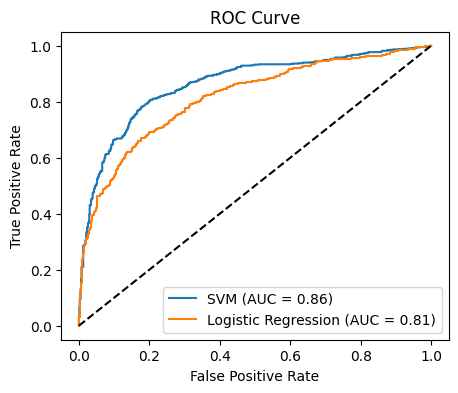

In [13]:
from sklearn.metrics import roc_curve, auc

fpr_svc, tpr_svc, _ = roc_curve(y_test, svc.predict_proba(X_test_scaled)[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:, 1])
roc_auc_svc = auc(fpr_svc, tpr_svc)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(5, 4))
plt.plot(fpr_svc, tpr_svc, label=f'SVM (AUC = {roc_auc_svc:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

 Code 8: Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

param_svm = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
grid_svm = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42), param_svm, cv=3)
grid_svm.fit(X_train_scaled, y_train)
print("Best SVM Parameters:", grid_svm.best_params_)
print("SVM CV Accuracy:", grid_svm.best_score_)

param_log = {'C': [0.01, 0.1, 1, 10]}
grid_log = GridSearchCV(LogisticRegression(max_iter=1000), param_log, cv=3)
grid_log.fit(X_train_scaled, y_train)
print("Best Logistic Regression C:", grid_log.best_params_['C'])
print("Logistic CV Accuracy:", grid_log.best_score_)


Best SVM Parameters: {'C': 10, 'gamma': 1}
SVM CV Accuracy: 0.8554709101069214
Best Logistic Regression C: 1
Logistic CV Accuracy: 0.7308512361436205


Code 9: Evaluate Tuned Models

In [15]:
y_pred_svm_tuned = grid_svm.best_estimator_.predict(X_test_scaled)
y_pred_log_tuned = grid_log.best_estimator_.predict(X_test_scaled)

print("\nTuned SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_tuned))
print("F1-score:", f1_score(y_test, y_pred_svm_tuned))
print("AUC:", roc_auc_score(y_test, grid_svm.best_estimator_.predict_proba(X_test_scaled)[:, 1]))

print("\nTuned Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log_tuned))
print("F1-score:", f1_score(y_test, y_pred_log_tuned))
print("AUC:", roc_auc_score(y_test, grid_log.best_estimator_.predict_proba(X_test_scaled)[:, 1]))



Tuned SVM Results
Accuracy: 0.8967193195625759
F1-score: 0.8996458087367178
AUC: 0.9514218639262935

Tuned Logistic Regression Results
Accuracy: 0.7339003645200486
F1-score: 0.7326007326007326
AUC: 0.814475549255847


Code 10: Bar charts of final results across models

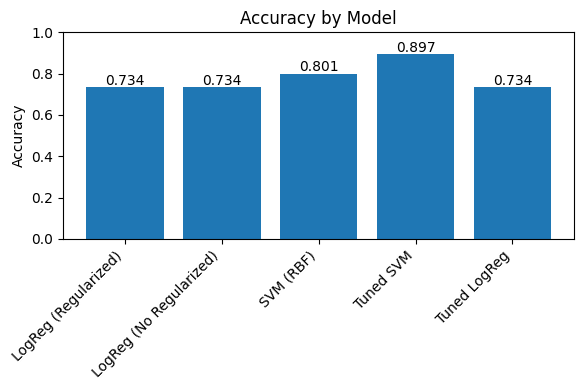

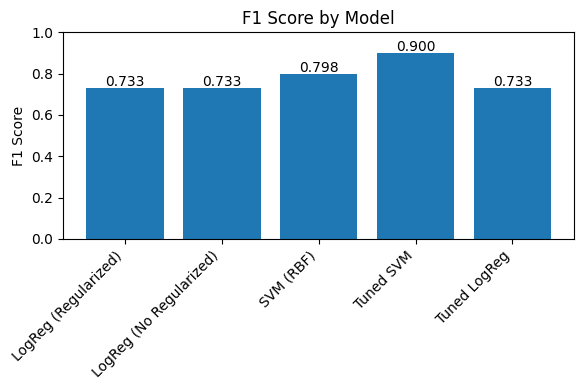

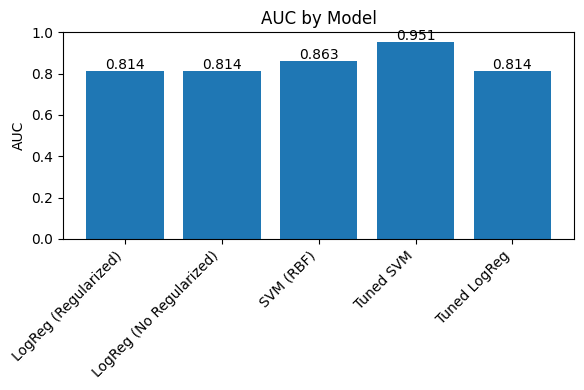

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Ensure all model and data variables are in memory (run Cells 1–9 first)

# Recompute predictions
y_pred_lr        = logreg.predict(X_test_scaled)
y_pred_noreg     = logreg_noreg.predict(X_test_scaled)
y_pred_svc       = svc.predict(X_test_scaled)
y_pred_svm_tuned = grid_svm.best_estimator_.predict(X_test_scaled)
y_pred_log_tuned = grid_log.best_estimator_.predict(X_test_scaled)

# Probability functions for AUC
prob_funcs = [
    lambda X: logreg.predict_proba(X)[:, 1],
    lambda X: logreg_noreg.predict_proba(X)[:, 1],
    lambda X: svc.predict_proba(X)[:, 1],
    lambda X: grid_svm.best_estimator_.predict_proba(X)[:, 1],
    lambda X: grid_log.best_estimator_.predict_proba(X)[:, 1]
]

# Model names and their predictions
models      = ["LogReg (Regularized)", "LogReg (No Regularized)", "SVM (RBF)", "Tuned SVM", "Tuned LogReg"]
predictions = [y_pred_lr, y_pred_noreg, y_pred_svc, y_pred_svm_tuned, y_pred_log_tuned]

# Compute each metric
accuracies = [accuracy_score(y_test, p) for p in predictions]
f1_scores  = [f1_score(     y_test, p) for p in predictions]
auc_scores = [roc_auc_score(y_test, prob_funcs[i](X_test_scaled)) for i in range(len(models))]

# Function to plot a bar chart for a metric
def plot_bar(metric, values):
    plt.figure(figsize=(6,4))
    plt.bar(models, values)
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f'{metric} by Model')
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.tight_layout()
    plt.show()

# Draw bar charts
plot_bar("Accuracy", accuracies)
plot_bar("F1 Score", f1_scores)
plot_bar("AUC", auc_scores)
